In [117]:
# Territory Conquest Simulation: High School Soccer with Team Colors and Logos

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
from pathlib import Path
import imageio
from matplotlib.gridspec import GridSpec

In [60]:
# === STEP 1: Load Match Data === #
df = pd.read_csv(r"C:\Users\User\OneDrive - 2020 Companies\Desktop\Ingraham Boys Soccer\metroleague_elo_log.csv")

def get_winner_loser(row):
    if row['Home Score'] > row['Away Score']:
        return pd.Series([row['Home Team'], row['Away Team']])
    elif row['Home Score'] < row['Away Score']:
        return pd.Series([row['Away Team'], row['Home Team']])
    else:
        return pd.Series([None, None])

# Add Winner and Loser columns
df[['Winner', 'Loser']] = df.apply(get_winner_loser, axis=1)
df = df[df['Winner'].notna()].reset_index(drop=True)
df = df[df['Season'] == '2024-25'].reset_index(drop=True)
df['Step'] = df.index + 1


In [49]:
# === STEP 2: Load Census Blocks === #
blocks = gpd.read_file(r"C:\Users\User\OneDrive - 2020 Companies\Desktop\Ingraham Boys Soccer\2025\KC_BLOCK_2020_PL.shp")
blocks = blocks.to_crs("EPSG:4326")
blocks['centroid'] = blocks.geometry.centroid
# Filter blocks to Seattle-ish area
blocks = blocks[
    (blocks['centroid'].y >= 47.45) & (blocks['centroid'].y <= 47.80) &
    (blocks['centroid'].x >= -122.45) & (blocks['centroid'].x <= -122.20)
].copy()



<ipython-input-49-a7032057f5ce>:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  blocks['centroid'] = blocks.geometry.centroid


In [61]:
# === STEP 3: Load Finalized School Coordinates from CSV ===
# Load school locations
schools = pd.read_csv(r"C:\Users\User\OneDrive - 2020 Companies\Desktop\Ingraham Boys Soccer\SchoolLocations.csv")

# Convert to GeoDataFrame
schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=gpd.points_from_xy(schools['longitude'], schools['latitude']),
    crs="EPSG:4326"
)


In [145]:
# === STEP 4: Assign Initial Territories ===
school_coords = schools_gdf[['longitude', 'latitude']].to_numpy()
block_coords = np.array(list(zip(blocks['centroid'].x, blocks['centroid'].y)))

nbrs = NearestNeighbors(n_neighbors=1).fit(school_coords)
_, indices = nbrs.kneighbors(block_coords)

blocks['initial_owner'] = schools_gdf.iloc[indices.flatten()]['Team'].values
blocks['owner'] = blocks['initial_owner']
territory_snapshots = {0: blocks.copy()}  



In [146]:
# === STEP 5: Simulate Match-Based Territory Changes ===
# Track win counts
win_counts = {team: 0 for team in blocks['initial_owner'].unique()}
territory_snapshots = {0: blocks.copy()}
territory_changes = []

# Updated simulation logic
for step, match in df.iterrows():
    winner = match.get('Winner')
    loser = match.get('Loser')
    home_team = match.get('Home Team')
    away_team = match.get('Away Team')
    home_score = match.get('Home Score')
    away_score = match.get('Away Score')

    blocks_before = blocks.copy()

    # === Handle Tie === #
    if pd.isna(winner) and pd.isna(loser):
        print(f"Step {step+1}: {home_team} vs {away_team} is a tie. No territory changes.")
        # ✅ Final snapshot (guarantees each step is saved, even with no changes)
        territory_snapshots[step + 1] = blocks.copy()
        continue

    # === Check win counts BEFORE this match ===
    winner_wins_before = win_counts.get(winner, 0)
    loser_wins_before = win_counts.get(loser, 0)

    # === Special Rule: Both teams have 0 wins BEFORE this match === #
    if winner_wins_before == 0 and loser_wins_before == 0:
        print(f"Step {step+1}: Special rule - both {winner} and {loser} had 0 wins.")
        blocks.loc[blocks['initial_owner'] == winner, 'owner'] = winner

    # === Proceed with normal logic ===
    blocks.loc[blocks['owner'] == loser, 'owner'] = winner
    blocks.loc[blocks['owner'] == loser, 'owner'] = None  # clear loser blocks

    # === Update win count AFTER processing ===
    win_counts[winner] = winner_wins_before + 1

    # === Winner Takes Loser's Territory === #
    blocks.loc[blocks['owner'] == loser, 'owner'] = winner

    # === Loser Loses All Their Territory === #
    blocks.loc[blocks['owner'] == loser, 'owner'] = None  # this re-applies due to order
    if (blocks['owner'].isna().all()) and pd.notna(winner) and pd.notna(loser):
        print(f"Step {step+1}: No team has territory — giving {loser}'s home territory to {winner}")
    blocks.loc[blocks['initial_owner'] == loser, 'owner'] = winner

    # === If no teams own any territory and winner/loser exists ===
    if (blocks['owner'].isna().all()) and pd.notna(winner) and pd.notna(loser):
        print(f"Step {step+1}: No team has territory — giving {loser}'s home territory to {winner}")
        blocks.loc[blocks['initial_owner'] == loser, 'owner'] = winner


    # === Track Wins === #
    if winner in win_counts:
        win_counts[winner] += 1

    # === Save Territory Snapshot === #
    territory_snapshots[step + 1] = blocks.copy()

    # === Log Territory Changes === #
    changed_blocks = blocks_before.merge(
        blocks[['GEOID', 'owner']], on='GEOID', suffixes=('_before', '_after')
    )
    changed_blocks = changed_blocks[changed_blocks['owner_before'] != changed_blocks['owner_after']]

    if not changed_blocks.empty:
        # Keep only the two relevant columns
        change_summary = changed_blocks[['owner_before', 'owner_after']].copy()

        # Drop rows where values are missing (e.g. None)
        change_summary = change_summary.dropna(subset=['owner_before', 'owner_after'])

        # Group and summarize
        change_summary = change_summary.groupby(['owner_after', 'owner_before']).size().reset_index(name='Blocks Changed')  
        change_summary.columns = ['Gaining Team', 'Losing Team', 'Blocks Changed']
        change_summary['Step'] = step + 1
        territory_changes.append(change_summary)
    # Add at the end of your simulation loop (inside for step, match in df.iterrows())
    territory_snapshots[step + 1] = blocks.copy()



Step 1: Special rule - both Lakeside (Seattle) and Nathan Hale had 0 wins.
Step 2: Special rule - both Seattle Prep and Garfield had 0 wins.
Step 3: Special rule - both Ballard and O'Dea had 0 wins.
Step 4: Special rule - both Ingraham and West Seattle had 0 wins.
Step 5: Special rule - both Chief Sealth and Rainier Beach had 0 wins.
Step 6: Special rule - both Nathan Hale and Seattle Academy had 0 wins.
Step 7: Special rule - both Eastside Catholic and Franklin had 0 wins.
Step 8: Special rule - both Bishop Blanchet and Roosevelt had 0 wins.
Step 12: Special rule - both Franklin and West Seattle had 0 wins.
Step 15: Special rule - both West Seattle and Cleveland had 0 wins.
Step 68: Special rule - both Cleveland and Rainier Beach had 0 wins.


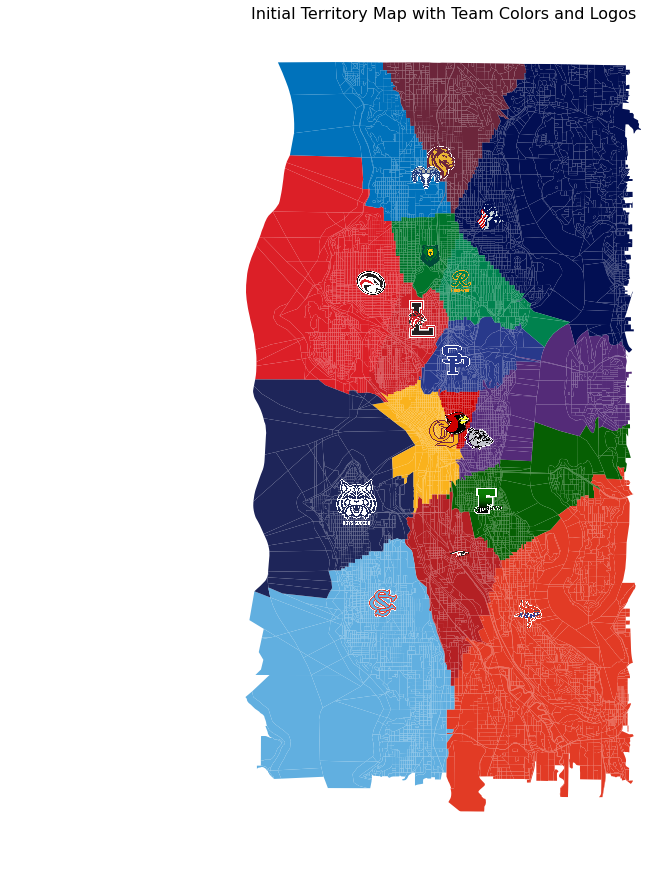

In [147]:
# === STEP 6: Visualize Initial Territories with Colors and Logos ===
logo_dir = r"C:\Users\User\OneDrive - 2020 Companies\Desktop\Ingraham Boys Soccer\School logos"

school_style = {
    'Ballard': {'color': '#dc1f27', 'logo': os.path.join(logo_dir, 'Ballard.png')},
    'Roosevelt': {'color': '#00824e', 'logo': os.path.join(logo_dir, 'Roosevelt.png')},
    'Garfield': {'color': '#542b78', 'logo': os.path.join(logo_dir, 'Garfield.png')},
    'Ingraham': {'color': '#0072BB', 'logo': os.path.join(logo_dir, 'Ingraham.png')},
    'Seattle Prep': {'color': '#28398b', 'logo': os.path.join(logo_dir, 'SeattlePrep.png')},
    'Eastside Catholic': {'color': '#ff6809', 'logo': os.path.join(logo_dir, 'eastside-catholic.png')},
    'Cleveland': {'color': '#b42024', 'logo': os.path.join(logo_dir, 'Cleveland.png')},
    'Chief Sealth': {'color': '#61afe0', 'logo': os.path.join(logo_dir, 'ChiefSealth.png')},
    'Lakeside (Seattle)': {'color': '#6c263b', 'logo': os.path.join(logo_dir, 'Lakeside.png')},
    'Nathan Hale': {'color': '#020f53', 'logo': os.path.join(logo_dir, 'NathanHale.png')},
    'West Seattle': {'color': '#1e2559', 'logo': os.path.join(logo_dir, 'WestSeattle.png')},
    "O'Dea": {'color': '#fab21c', 'logo': os.path.join(logo_dir, "ODea.png")},
    'Rainier Beach': {'color': '#e23b25', 'logo': os.path.join(logo_dir, 'RainierBeach.png')},
    'Bishop Blanchet': {'color': '#00742b', 'logo': os.path.join(logo_dir, 'BishopBlanchet.png')},
    'Lincoln (Seattle)': {'color': '#cd2027', 'logo': os.path.join(logo_dir, 'Lincoln.png')},
    'Seattle Academy': {'color': '#cc0001', 'logo': os.path.join(logo_dir, 'SeattleAcademy.png')},
    'Franklin': {'color': '#065f03', 'logo': os.path.join(logo_dir, 'Franklin.png')},
}


# Add color to GeoDataFrame
blocks['color'] = blocks['initial_owner'].map(lambda team: school_style.get(team, {}).get('color', '#cccccc'))

fig, ax = plt.subplots(figsize=(12, 12))
blocks.plot(color=blocks['color'], ax=ax, edgecolor='none')

# Function to add logos
def add_logo(ax, row):
    team = row['Team']
    logo_path = school_style.get(team, {}).get('logo')
    if logo_path and os.path.exists(logo_path):
        img = mpimg.imread(logo_path)
        imagebox = OffsetImage(img, zoom=0.05)
        ab = AnnotationBbox(imagebox, (row.geometry.x, row.geometry.y), frameon=False)
        ax.add_artist(ab)

schools_gdf.apply(lambda row: add_logo(ax, row), axis=1)

ax.set_title("Initial Territory Map with Team Colors and Logos", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


In [148]:
def plot_snapshot(step, blocks_snapshots, school_style, schools_gdf, df, title_prefix="Territory Map - Step"):
    import matplotlib.pyplot as plt
    from matplotlib.offsetbox import OffsetImage, AnnotationBbox
    import matplotlib.image as mpimg
    import os

    snapshot = blocks_snapshots[step].copy()
    snapshot['color'] = snapshot['owner'].map(lambda team: school_style.get(team, {}).get('color', '#cccccc'))

    fig, ax = plt.subplots(figsize=(12, 12))
    snapshot.plot(color=snapshot['color'], ax=ax, edgecolor='none')

    # Add logos
    def add_logo(ax, row):
        team = row['Team']
        logo_path = school_style.get(team, {}).get('logo')
        if logo_path and os.path.exists(logo_path):
            img = mpimg.imread(logo_path)
            imagebox = OffsetImage(img, zoom=0.05)
            ab = AnnotationBbox(imagebox, (row.geometry.x, row.geometry.y), frameon=False)
            ax.add_artist(ab)

    schools_gdf.apply(lambda row: add_logo(ax, row), axis=1)

    # === Add Title & Match Info ===
    ax.set_title(f"{title_prefix} {step}", fontsize=16)

    if step > 0 and step - 1 < len(df):
        match = df.iloc[step - 1]
        home, away = match['Home Team'], match['Away Team']
        score = f"{home} {match['Home Score']} - {match['Away Score']} {away}"
        ax.text(0.5, 0.96, score, fontsize=12, ha='center', transform=ax.transAxes)

    ax.axis('off')
    plt.tight_layout()
    plt.show()


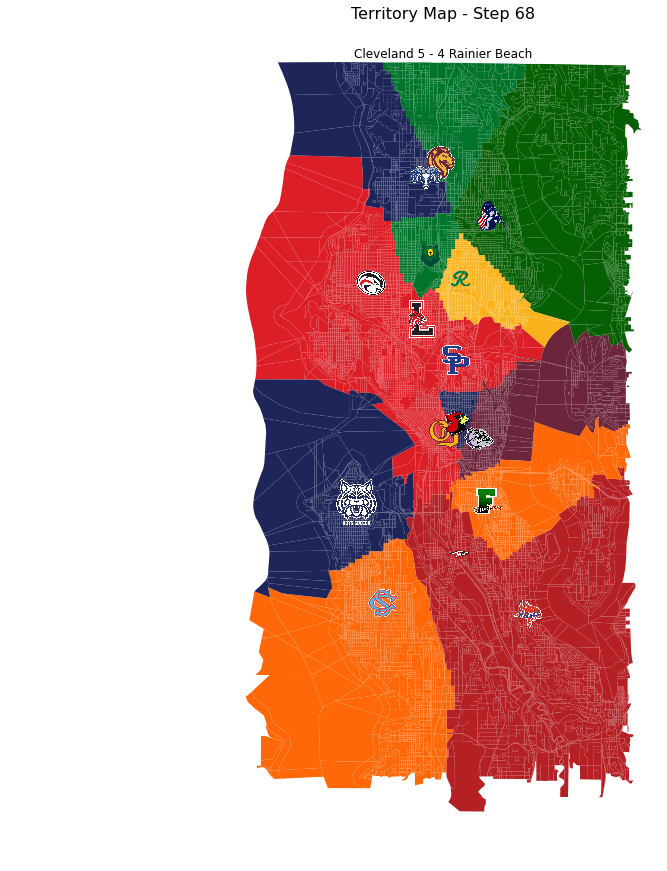

In [156]:
plot_snapshot(68, territory_snapshots, school_style, schools_gdf, df)


In [ ]:
output_dir = "C:\Users\User\OneDrive - 2020 Companies\Desktop\Ingraham Boys Soccer\frames"
os.makedirs(output_dir, exist_ok=True)
frame_files = []

# Generate one frame per snapshot
for step in range(0, 109):  # Game 0 to 108
    if step not in territory_snapshots:
        continue  # skip missing steps

    fig, ax = plt.subplots(figsize=(12, 12))
    snapshot = territory_snapshots[step].copy()
    snapshot['color'] = snapshot['owner'].map(lambda team: school_style.get(team, {}).get('color', '#cccccc'))
    snapshot.plot(color=snapshot['color'], ax=ax, edgecolor='none')

    # Add logos
    def add_logo(ax, row):
        team = row['Team']
        logo_path = school_style.get(team, {}).get('logo')
        if logo_path and os.path.exists(logo_path):
            img = mpimg.imread(logo_path)
            imagebox = OffsetImage(img, zoom=0.05)
            ab = AnnotationBbox(imagebox, (row.geometry.x, row.geometry.y), frameon=False)
            ax.add_artist(ab)

    schools_gdf.apply(lambda row: add_logo(ax, row), axis=1)

    # Add step info and match result
    ax.set_title(f"Territory Map - Game {step}", fontsize=16)
    if step > 0 and step - 1 < len(df):
        match = df.iloc[step - 1]
        home, away = match['Home Team'], match['Away Team']
        hs, as_ = match['Home Score'], match['Away Score']
        result = f"{home} {hs} - {as_} {away}"
        ax.text(0.5, 0.96, result, fontsize=12, ha='center', transform=ax.transAxes)

    ax.axis('off')
    frame_path = os.path.join(output_dir, f"frame_{step:03d}.png")
    plt.savefig(frame_path, bbox_inches='tight', pad_inches=0.1)
    frame_files.append(frame_path)
    plt.close()

# Create animated GIF
imageio.mimsave(r'C:\Users\User\OneDrive - 2020 Companies\Desktop\Ingraham Boys Soccer\territory_simulation.gif', [imageio.imread(f) for f in frame_files], fps=2)
print("✅ GIF created: territory_simulation.gif")

✅ GIF created: territory_simulation.gif
